In [37]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]




def remove_speakers_and_empty_lines(episode_content: str) -> str:
    """Removes superfluous empty lines and the names of the speakers from the input data:
    e.g. :
    Picard: Make it so.
    becomes:
    Make it so.
    """

    cleaned_lines = []
    for line in episode_content.split('\n'):
        # ignore empty lines
        if line == '':
            continue
        # lines that start with square brackets are just information about the location.
        if line.startswith('['):
            continue
        # the actual talking lines always contain a ':' - we will just keep the text, not the talker
        # for this application
        if ':' in line:
            part_to_keep = line.split(':')[1]
            cleaned_lines.append(part_to_keep.strip() + ' \n')
            continue
        # after this string there are only information about the franchise, we can leave those out.
        if line == '<Back':
            break
        
        
        cleaned_lines.append(line.strip() + ' \n')
    return ''.join(cleaned_lines)


all_series_scripts = pd.read_json('all_scripts_raw.json')
#  remove the names of the speakers and get rid of the empty lines
# and I'll focus on The Next Generation Episodes for now
tng_series_scripts_cleaned = all_series_scripts.TNG.map(remove_speakers_and_empty_lines)



<FreqDist with 26299 samples and 1031138 outcomes>


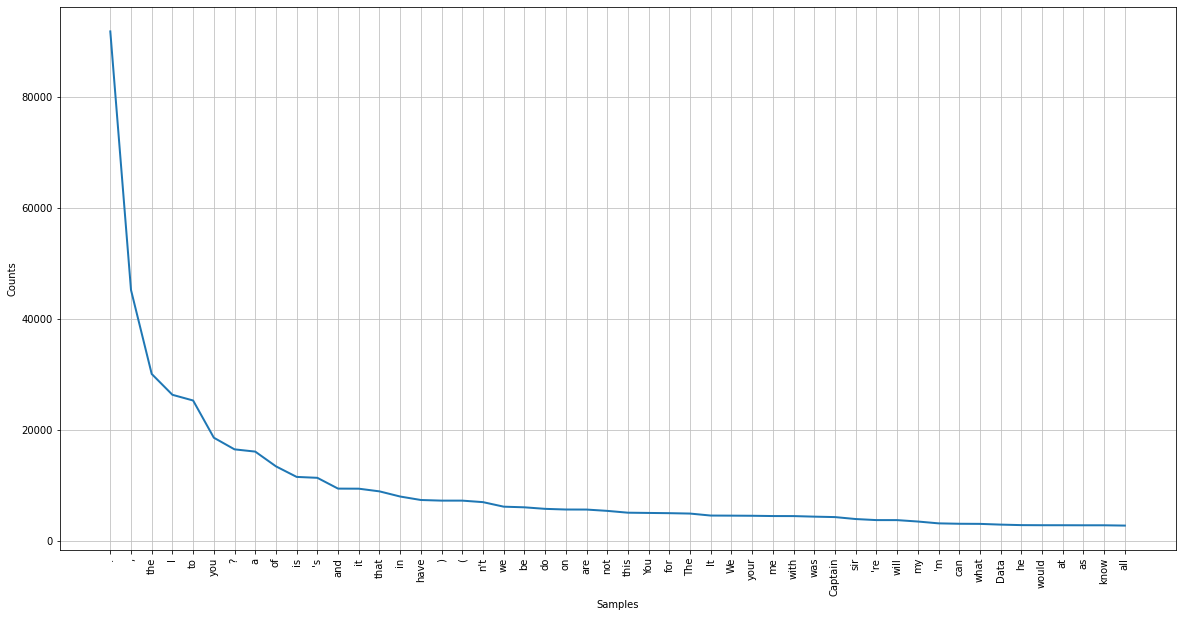

26299
10508
['encyclopedia', 'stealthily', 'slink', 'Glide', 'skulk', 'pussyfoot', 'gumshoe', 'Elizabethan', 'plumed', 'whence', 'camest', 'dost', 'wouldst', '20th', 'patriotism', 'commies', 'god-images', 'snort', 'Self-righteous', 'Prosecute', 'Facts', 'veritable', 'Fight', 'Sense', 'detaching', 'Inadvisable', 'print-out', 'swoop', 'Accelerating', 'Magnifying', 'Print-out', 'unnamed', 'detach', 'stardrive', 'Gracefully', 'hand-brake', 'pursuer', 'Decelerating', 'Oriental', 'Historically', 'Mid', 'respectful', 'spotlight', 'savageries', '2036', 'Nations', 'forbears', 'freezes', 'barbarian', 'thaw', 'Lose', 'prosecutor', 'Accepted', 'merciful', 'lawyers', 'grievously', 'Grievously', 'Guns', 'Soldiers', 'triggers', 'Provisionally', 'abiding', 'Luxurious', 'abundant', 'Geothermal', 'apples', 'Enjoying', 'mall', 'Useful', 'Investigating', 'alertness', 'inventing', 'Stardrive', 'WT', 'mill', 'reconnection', 'candidly', 'compromising', 'geniality', 'bio-electronic', 'orbs', 'painkillers', 'E

In [38]:
# after this preprocessing we want to check for outliers in the data
# thinks like miss spelled words etc.
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize


# lets make a single text from all episodes.
text = ''
for index, episode_text in tng_series_scripts_cleaned.items():
    text += episode_text


# tokenize the text
tokenized_text =  word_tokenize(text)

fd = FreqDist(tokenized_text)
print(fd)
fd.plot(50)
print(len(fd))
print(len(fd.hapaxes()))
# as we can see here, our corpus contains 26299 different words - though we did not do any normalization like casefolding, stemming or lemmatization, so the actual different words will be less
# whats even more astounding for me is number of words that occur only once: almost half of all words!
# this approach apparently isnt helpful in finding missspelled words
# but lets see if we can glimpse whether those are misspelled words
print(fd.hapaxes()[:100])

In [39]:
# so, there are almost no spelling mistakes - that is good news! this should allow us to continue for now.

# now we can have a look whether it makes sense to combine words into combined tokens based on their cooccurence.
from gensim.models.phrases import Phrases
from nltk.tokenize import sent_tokenize
# gensims Phrases class expects a sequence of sentences, where each sentence is a list of tokens
sentences = sent_tokenize(text)
word_tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]

bigrams = Phrases(word_tokenized_sentences)

# lets test that on the first episode
first_episode_bigrams = bigrams[word_tokenize(tng_series_scripts_cleaned[0])]
print(first_episode_bigrams)

# now that looks good - not too many bigrams, but a few typical combinations like tractor beam have been found.

', ',', 'sir', '.', "They_'re", 'hitting', 'the', 'old', 'Bandi', 'city', ',', 'not', 'Farpoint_Station', '.', '(', 'The', 'ruined', 'and', 'empty', 'city', 'is', 'being', 'smashed', 'by', 'purple', 'blasts', ')', '(', 'The', 'away_team', 'can', 'hear', 'the', 'blasts', ')', 'Those', 'stairs', 'are', 'where', 'we', 'entered', 'down', 'here', ',', 'sir', '.', 'At', 'this', 'point', ',', 'it', 'becomes', 'ordinary', 'stone', ',', 'sir', '.', 'Matching', 'what', "'s", 'above', '.', 'My_God', '!', 'Was', 'that', 'a', 'phaser_blast', '?', 'Negative', '.', 'But', 'something', 'similar', '.', 'You', ',', 'Tasha', ',', 'and', 'Geordi', 'will', 'beam', 'up', 'to', 'the', 'ship', '.', 'Now', ',', 'come', 'on', ',', 'I', 'want', 'to', 'see', 'exactly_what', "'s", 'happening', '.', "Do_n't", '.', 'If', 'you', 'should', 'be', 'hurt', 'You', 'have', 'your', 'orders', ',', 'Lieutenant', '.', 'Carry', 'them', 'out', '.', 'Yes', 'sir', ',', 'I', "'m_sorry", ',', 'sir', '.', 'Enterprise', ',', 'three', 

In [ ]:
# lets save that model to use in later steps
from gensim.models.phrases import Phraser
bigram_model = Phraser(bigrams)
bigram_model.save('bigram_model.pkl')